In [ ]:
# using dataframes stored in /dfs, compute cosine similarity between each left ADMN sensory neuron

In [14]:
# import packages
import pandas as pd
import numpy as np

from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [4]:
# call in sn_connectivity dataframe
full_df = pd.read_pickle("dfs/sn_connectivity.pkl")

In [5]:
# limit to connections with five synapses
# long - 2 min 12 sec

# function from tuthill-lab/Lesser_Azevedo_2023
def group_and_count_inputs(df, thresh):

    # count the number of synapses between pairs of pre and post synaptic inputs
    syn_in_conn=df.groupby(['pre_pt_root_id','post_pt_root_id']).transform(len)['id']
    # save this result in a new column and reorder the index
    df['syn_in_conn']=syn_in_conn
    df = df[['id', 'pre_pt_root_id','post_pt_root_id','score','syn_in_conn']].sort_values('syn_in_conn', ascending=False).reset_index()

    # Filter out small synapses between pairs of neurons and now print the shape
    df = df[df['syn_in_conn']>=thresh]
    # print(df.shape)
    return df

df = group_and_count_inputs(full_df,thresh=5)

In [6]:
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    return clustered_order

In [7]:
def organize_by_cos_long(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[clustered_order,:]
    sim_mat = cosine_similarity(reordered_df.to_numpy())
    
    
    return reordered_df

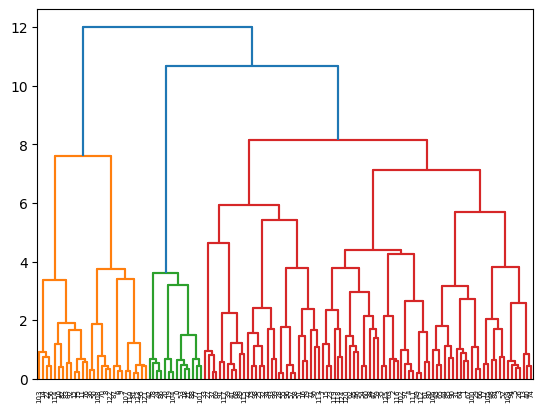

In [9]:
# ordered adjacency matrix
adj = pd.crosstab(df.pre_pt_root_id,df.post_pt_root_id)
adj_ordered = organize_by_cos_long(df)

Text(0.5, 1.0, 'SN sim')

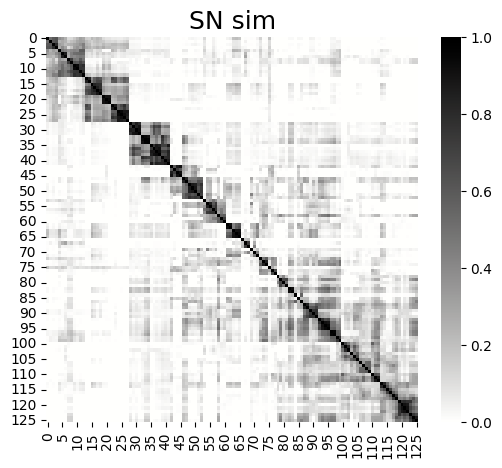

In [15]:
# visualize 

sim_mat = cosine_similarity(adj_ordered.to_numpy())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat, cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('SN sim', fontsize = 18)

# plt.show()

# plt.savefig('../SN_simmat_0725.svg', format='svg', bbox_inches='tight')